# Initialize

## Imports

In [1]:
from mmhuman3d.data.data_structures.human_data import HumanData
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8'
C:\Users\owner\anaconda3\envs\open-mmlab\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Path

In [2]:
data_root = Path('D:/MMLAB/mmhuman3d/data/Samples/run_0/')
input_vid = data_root/ 'yoga.mp4'
mesh_vid = data_root/ 'smplx.mp4'
output_vid = data_root/ 'output.mp4'

## Constants

In [3]:
keypoints_dict ={0:"right ankle",1:"right knee", 2:"right hip", 3:"left hip", 4:"left knee", 5:"left ankle", 6:"right wrist", 7:"right elbow", 8:"right shoulder", 9:"left shoulder", 10:"left elbow", 11:"left wrist", 12:"neck", 13:"head top"}

data = {
    "Pelvis": {"CoM": 0.5, "Mass": 0.142, "Radius of gyration": 0.31, "proximal": "right hip" , "distal": "left hip"},
    "Thorax_a": {"CoM": 0.63, "Mass": 0.355/2, "Radius of gyration": 0.31, "proximal": "left hip" , "distal": "neck"},
    "Thorax_b": {"CoM": 0.63, "Mass": 0.355/2, "Radius of gyration": 0.31, "proximal": "right hip" , "distal": "neck"},
    "Head": {"CoM": 0.5, "Mass": 0.081, "Radius of gyration": 1.116, "proximal": "neck" , "distal": "head top"},
    "Right Femur": {"CoM": 0.567, "Mass": 0.1, "Radius of gyration": 0.54, "proximal": "right hip" , "distal": "right knee"},
    "Left Femur": {"CoM": 0.567, "Mass": 0.1, "Radius of gyration": 0.54, "proximal": "left hip" , "distal": "left knee"},
    "Right Tibia": {"CoM": 0.567, "Mass": 0.0465, "Radius of gyration": 0.528, "proximal": "right knee" , "distal": "right ankle"},
    "Left Tibia": {"CoM": 0.567, "Mass": 0.0465, "Radius of gyration": 0.528, "proximal": "left knee" , "distal": "left ankle"},
    "Right Humorous": {"CoM": 0.564, "Mass": 0.028, "Radius of gyration": 0.542, "proximal": "right shoulder" , "distal": "right elbow"},
    "Left Humorous": {"CoM": 0.564, "Mass": 0.028, "Radius of gyration": 0.542, "proximal": "left shoulder" , "distal": "left elbow"},
    "Right Radius": {"CoM": 0.57, "Mass": 0.016, "Radius of gyration": 0.526, "proximal": "right elbow" , "distal": "right wrist"},
    "Left Radius": {"CoM": 0.57, "Mass": 0.016, "Radius of gyration": 0.526, "proximal": "left elbow" , "distal": "left wrist"},
    #"Foot": {"CoM": 0.5, "Mass": 0.0145, "Radius of gyration": 0.69, "proximal": "L5/S1" , "distal": "Hip"},
    #"Hand": {"CoM": 0.6205, "Mass": 0.006, "Radius of gyration": 0.44, "proximal": "L5/S1" , "distal": "Hip"},
}
# 
segments_mat = pd.DataFrame(data).T
# redistribute the Mass so the sum will be 1 
segments_mat['Mass'] = segments_mat['Mass'] / segments_mat['Mass'].sum()
# add to each segment the index of the proximal and distal segment from the keypoints_dict
segments_mat['proximal_idx'] = segments_mat['proximal'].apply(lambda x: list(keypoints_dict.keys())[list(keypoints_dict.values()).index(x)])
segments_mat['distal_idx'] = segments_mat['distal'].apply(lambda x: list(keypoints_dict.keys())[list(keypoints_dict.values()).index(x)])

segments_mat

,CoM,Mass,Radius of gyration,proximal,distal,proximal_idx,distal_idx
Pelvis,0.5,0.148071,0.31,right hip,left hip,2,3
Thorax_a,0.63,0.185089,0.31,left hip,neck,3,12
Thorax_b,0.63,0.185089,0.31,right hip,neck,2,12
Head,0.5,0.084463,1.116,neck,head top,12,13
Right Femur,0.567,0.104275,0.54,right hip,right knee,2,1
Left Femur,0.567,0.104275,0.54,left hip,left knee,3,4
Right Tibia,0.567,0.048488,0.528,right knee,right ankle,1,0
Left Tibia,0.567,0.048488,0.528,left knee,left ankle,4,5
Right Humorous,0.564,0.029197,0.542,right shoulder,right elbow,8,7
Left Humorous,0.564,0.029197,0.542,left shoulder,left elbow,9,10


## Load HumanData   

In [4]:
h_data = HumanData.fromfile(data_root /'inference_result.npz')
keypoints = h_data['keypoints3d'][:, :, :3]

## Visualization functions

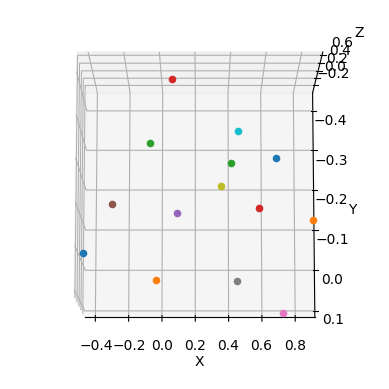

In [5]:

def visualize_3d_keypoints(keypoints,M = None,bound = True):
    # Extracting dimensions
    k, _ = keypoints.shape
    # Initialize figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if bound:
        # Setting axis limits (You might need to adjust these based on your data)
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_zlim([-1,1])
    else:
        ax.set_xlim([keypoints[:,0].min(),keypoints[:,0].max()])
        ax.set_ylim([keypoints[:,1].min(),keypoints[:,1].max()])
        ax.set_zlim([keypoints[:,2].min(),keypoints[:,2].max()])
    
    # rotate the 3d plot x zero, y zero is at the bottom left
    #
    # set origin top left corner
    ax.invert_yaxis()
    current_view = ax.view_init()
    ax.view_init(elev=80, azim=-90,roll=0)
    
    # Plot keypoints
    for i in range(k):
        ax.scatter(keypoints[i,0], keypoints[i,1], keypoints[i,2])
        # add number to each keypoint
        #ax.text(keypoints[i,0], keypoints[i,1], keypoints[i,2], '%s' % (str(keypoints_dict[i])), size=10, zorder=1, color='k')
    if M is not None:
        ax.scatter(M[0], M[1], M[2], c='r', marker='o')
        ax.text(M[0], M[1], M[2], 'CoM', size=10, zorder=1, color='k')
        
    return fig

# Example usage
# Assuming you have defined keypoints_array and M
visualize_3d_keypoints(keypoints[0,:,:],bound = False);

# Calculate Center of Mass

In [6]:
l = segments_mat.CoM.values
w = segments_mat.Mass.values

proximal,distal = keypoints[:,segments_mat.proximal_idx.values,:], keypoints[:,segments_mat.distal_idx.values,:]
p_com = (proximal * l[:,None] + distal * (1-l)[:,None])
# M is the matrix that average over the keypoints using the weights (w)
M = np.sum(p_com * w[None,:,None], axis = 1)
M.shape

(97, 3)

In [7]:
import plotly.graph_objects as go
import webbrowser



def scatter_3d(data_list, output_html ="", names = None, colors =None, size = 5):
    if isinstance(size, int):
        size = [size]*len(data_list)
    if not isinstance(size, list) :
        raise ValueError("size should be an integer or a list of integers") 
    if colors is None:
        colors = ["blue","red","green","yellow","black","purple","orange","pink","brown","cyan","magenta","grey","lightblue"]
    if names is None:
        names = [f"Data {i}" for i in range(len(data_list))]
    

    # Create figure
    fig = go.Figure()
    for j, data in enumerate(data_list):
        fig.add_trace(go.Scatter3d(x=data[0, :, 0], y=data[0, :, 1], z=data[0, :, 2],
                                   mode="markers", marker=dict(size=size[j], color=colors[j]),
                                   name=names[j]),
                      )
    # Combine frames alternately
    max_length = max([len(data) for data in data_list])
    
    # Define frames where both data and M are updated
    all_frames = []
    for i in range(max_length):
        frame_data = []
        for j, data in enumerate(data_list):
            if i < len(data):
                frame_data.append(go.Scatter3d(x=data[i, :, 0], y=data[i, :, 1], z=data[i, :, 2],
                                               mode="markers", marker=dict(size=size[j], color=colors[j]),)
                                  )
    
        all_frames.append(go.Frame(data=frame_data, name=f'frame{i}'))
    
    # Update frames
    fig.update(frames=all_frames)
    
    
    
    
    def frame_args(duration):
        return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }
    
    
    sliders = [
        {"pad": {"b": 10, "t": 60},
         "len": 0.9,
         "x": 0.1,
         "y": 0,
    
         "steps": [
             {"args": [[f.name], frame_args(0)],
              "label": str(k),
              "method": "animate",
              } for k, f in enumerate(fig.frames)
         ]
         }
    ]
    
    fig.update_layout(
        updatemenus=[{"buttons": [
            {
                "args": [None, frame_args(50)],
                "label": "Play",
                "method": "animate",
            },
            {
                "args": [[None], frame_args(0)],
                "label": "Pause",
                "method": "animate",
            }],
            "direction": "left",
            "pad": {"r": 10, "t": 70},
            "type": "buttons",
            "x": 0.1,
            "y": 0,
        }
        ],
        sliders=sliders,
        scene=dict(xaxis=dict(range=[-1.2, 1.2], autorange=False),
                   yaxis=dict(range=[-1.2, 1.2], autorange=False),
                   zaxis=dict(range=[-1.2, 1.2], autorange=False),
                   aspectmode="cube"
    
                   )
    )
    # invert the y axis (ax.invert_yaxis())
    
    # setup the initial view of the 3d plot so the top left corner is -1,-1
    fig.update_layout(scene=dict(camera=dict(up=dict(x=0, y=0, z=0),
                                             center=dict(x=0, y=0, z=0),
                                             eye=dict(x=1, y=-1, z=-2)
                                             )
                                   )
                      )
    # change to white theme
    fig.update_layout(template="plotly_white")
    
    # Save the figure as an HTML file
    if output_html:
        if not output_html.endswith(".html"):
            output_html += ".html"
        fig.write_html(output_html)
        webbrowser.open(output_html)
    
    return fig

f = scatter_3d(data_list =[keypoints,np.expand_dims(M.copy(), 1)],
           output_html = str(data_root/'3d_keypoints.html'),
           names = ["Keypoints", "CoM"],
           colors = ["blue", "red"],
           size = 5)       

# use paper volume to calculate the CoM

In [181]:
from itay.utils.part_volumes import PartVolume 
import torch.nn as nn
import pickle as pkl
import os.path as osp
ESSENTIALS_DIR = 'D:/MMLAB/mmhuman3d/itay/data/essentials'
SMPL_PART_BOUNDS = f'{ESSENTIALS_DIR}/yogi_segments/smpl/part_meshes_ply/smpl_segments_bounds.pkl'
FID_TO_PART = f'{ESSENTIALS_DIR}/yogi_segments/smpl/part_meshes_ply/fid_to_part.pkl'
PART_VID_FID = f'{ESSENTIALS_DIR}/yogi_segments/smpl/part_meshes_ply/smpl_part_vid_fid.pkl'
HD_SMPL_MAP  = f'{ESSENTIALS_DIR}/hd_model/smpl/smpl_neutral_hd_sample_from_mesh_out.pkl'


In [182]:
def sparse_batch_mm(m1, m2):
    """
    https://github.com/pytorch/pytorch/issues/14489

    m1: sparse matrix of size N x M
    m2: dense matrix of size B x M x K
    returns m1@m2 matrix of size B x N x K
    """

    batch_size = m2.shape[0]
    # stack m2 into columns: (B x N x K) -> (N, B, K) -> (N, B * K)
    m2_stack = m2.transpose(0, 1).reshape(m1.shape[1], -1)
    result = m1.mm(m2_stack).reshape(m1.shape[0], batch_size, -1) \
               .transpose(1, 0)
    return result

class HDfier():
    def __init__(self, model_type='smpl', device='cuda'):
        hd_operator_path = osp.join(ESSENTIALS_DIR, 'hd_model', model_type,
                                    f'{model_type}_neutral_hd_vert_regressor_sparse.npz')
        hd_operator = np.load(hd_operator_path)
        self.hd_operator = torch.sparse.FloatTensor(
            torch.tensor(hd_operator['index_row_col']),
            torch.tensor(hd_operator['values']),
            torch.Size(hd_operator['size']))
        self.model_type = model_type
        self.device = device

    def hdfy_mesh(self, vertices):
        """
        Applies a regressor that maps SMPL vertices to uniformly distributed vertices
        """
        # device = body.vertices.device
        # check if vertices ndim are 3, if not , add a new axis
        if vertices.dim() != 3:
            # batchify the vertices
            vertices = vertices[None, :, :]

        # check if vertices are an ndarry, if yes, make pytorch tensor
        if isinstance(vertices, np.ndarray):
            vertices = torch.from_numpy(vertices).to(self.device)

        vertices = vertices.to(torch.double)

        if self.hd_operator.device != vertices.device:
            self.hd_operator = self.hd_operator.to(vertices.device)
        hd_verts = sparse_batch_mm(self.hd_operator, vertices).to(torch.float)
        return hd_verts

In [183]:
class StabilityLossCoP(nn.Module):
    def __init__(self,
                 faces,
                 cop_w = 10,
                 cop_k = 100,
                 contact_thresh=0.1,
                 model_type='smpl',
                 device='cuda',
    ):
        super().__init__()
        """
        Loss that ensures that the COM of the SMPL mesh is close to the center of support 
        """
        if model_type == 'smpl':
            num_faces = 13776
            num_verts_hd = 20000

        assert faces is not None, 'Faces tensor is none'
        if type(faces) is not torch.Tensor:
            faces = torch.tensor(faces.astype(np.int64), dtype=torch.long).to(device)
        self.register_buffer('faces', faces)

        self.cop_w = cop_w
        self.cop_k = cop_k
        self.contact_thresh = contact_thresh

        self.hdfy_op = HDfier(model_type=model_type)

        with open(SMPL_PART_BOUNDS, 'rb') as f:
            d = pkl.load(f)
            self.part_bounds = {k: d[k] for k in sorted(d)}
        self.part_order = sorted(self.part_bounds)

        with open(PART_VID_FID, 'rb') as f:
            self.part_vid_fid = pkl.load(f)

        # mapping between vid_hd and fid
        with open(HD_SMPL_MAP, 'rb') as f:
            faces_vert_is_sampled_from = pkl.load(f)['faces_vert_is_sampled_from']
        index_row_col = torch.stack(
            [torch.LongTensor(np.arange(0, num_verts_hd)), torch.LongTensor(faces_vert_is_sampled_from)], dim=0)
        values = torch.ones(num_verts_hd, dtype=torch.float)
        size = torch.Size([num_verts_hd, num_faces])
        hd_vert_on_fid = torch.sparse.FloatTensor(index_row_col, values, size)

        # mapping between fid and part label
        with open(FID_TO_PART, 'rb') as f:
            fid_to_part_dict = pkl.load(f)
        fid_to_part = torch.zeros([len(fid_to_part_dict.keys()), len(self.part_order)], dtype=torch.float32)
        for fid, partname in fid_to_part_dict.items():
            part_idx = self.part_order.index(partname)
            fid_to_part[fid, part_idx] = 1.

        # mapping between vid_hd and part label
        self.hd_vid_in_part = self.vertex_id_to_part_mapping(hd_vert_on_fid, fid_to_part)

    def compute_triangle_area(self, triangles):
        ### Compute the area of each triangle in the mesh
        # Compute the cross product of the two vectors of each triangle
        # Then compute the length of the cross product
        # Finally, divide by 2 to get the area of each triangle

        vectors = torch.diff(triangles, dim=2)
        crosses = torch.cross(vectors[:, :, 0], vectors[:, :, 1])
        area = torch.norm(crosses, dim=2) / 2
        return area

    def compute_per_part_volume(self, vertices):
        """
        Compute the volume of each part in the reposed mesh
        """
        part_volume = []
        for part_name, part_bounds in self.part_bounds.items():
            # get part vid and fid
            part_vid = torch.LongTensor(self.part_vid_fid[part_name]['vert_id']).to(vertices.device)
            part_fid = torch.LongTensor(self.part_vid_fid[part_name]['face_id']).to(vertices.device)
            pv = PartVolume(part_name, vertices, self.faces)
            for bound_name, bound_vids in part_bounds.items():
                pv.close_mesh(bound_vids)
            # add extra vids and fids to original part ids
            new_vert_ids = torch.LongTensor(pv.new_vert_ids).to(vertices.device)
            new_face_ids = torch.LongTensor(pv.new_face_ids).to(vertices.device)
            part_vid = torch.cat((part_vid, new_vert_ids), dim=0)
            part_fid = torch.cat((part_fid, new_face_ids), dim=0)
            pv.extract_part_triangles(part_vid, part_fid)
            part_volume.append(pv.part_volume())
        return torch.vstack(part_volume).permute(1,0).to(vertices.device)

    def vertex_id_to_part_volume_mapping(self, per_part_volume, device):
        batch_size = per_part_volume.shape[0]
        self.hd_vid_in_part = self.hd_vid_in_part.to(device)
        hd_vid_in_part = self.hd_vid_in_part[None, :, :].repeat(batch_size, 1, 1)
        vid_to_vol = torch.bmm(hd_vid_in_part, per_part_volume[:, :, None])
        return vid_to_vol

    def vertex_id_to_part_mapping(self, hd_vert_on_fid, fid_to_part):
        vid_to_part = torch.mm(hd_vert_on_fid, fid_to_part)
        return vid_to_part

    def forward(self, vertices):
        # Note: the vertices should be aligned along y-axis and in world coordinates
        batch_size = vertices.shape[0]
        # calculate per part volume
        per_part_volume = self.compute_per_part_volume(vertices)
        # sample 20k vertices uniformly on the smpl mesh
        vertices_hd = self.hdfy_op.hdfy_mesh(vertices)
        # get volume per vertex id in the hd mesh
        volume_per_vert_hd = self.vertex_id_to_part_volume_mapping(per_part_volume, vertices.device)
        # calculate com using volume weighted mean
        com = torch.sum(vertices_hd * volume_per_vert_hd, dim=1) / torch.sum(volume_per_vert_hd, dim=1)

        # # get COM of the SMPLX mesh
        # triangles = torch.index_select(vertices, 1, self.faces.view(-1)).reshape(batch_size, -1, 3, 3)
        # triangle_centroids = torch.mean(triangles, dim=2)
        # triangle_area = self.compute_triangle_area(triangles)
        # com_naive = torch.einsum('bij,bi->bj', triangle_centroids, triangle_area) / torch.sum(triangle_area, dim=1)

        # pressure based center of support
        ground_plane_height = 0.0
        eps = 1e-6
        vertex_height = (vertices_hd[:, :, 1] - ground_plane_height)
        inside_mask = (vertex_height < 0.0).float()
        outside_mask = (vertex_height >= 0.0).float()
        pressure_weights = inside_mask * (1-self.cop_k*vertex_height) + outside_mask *  torch.exp(-self.cop_w * vertex_height)
        cop = torch.sum(vertices_hd * pressure_weights.unsqueeze(-1), dim=1) / (torch.sum(pressure_weights, dim=1, keepdim=True) +eps)

        # naive center of support
        # vertex_height_robustified = GMoF_unscaled(rho=self.gmof_rho)(vertex_height)
        contact_confidence = torch.sum(pressure_weights, dim=1)
        # contact_mask = (vertex_height < self.contact_thresh).float()
        # num_contact_verts = torch.sum(contact_mask, dim=1)
        # contact_centroid_naive = torch.sum(vertices_hd * contact_mask[:, :, None], dim=1) / (torch.sum(contact_mask, dim=1) + eps)

        # project com, cop to ground plane (x-z plane)
        # weight loss by number of contact vertices to zero out if zero vertices in contact
        return com, cop, contact_confidence
        


In [184]:
body_model_config = dict(
            type='smplx',
            num_betas=10,
            use_face_contour=True,
            use_pca=False,
            flat_hand_mean=True,
            model_path='D:/MMLAB/mmhuman3d/data/body_models/smplx',
            keypoint_src='smplx',
            keypoint_dst='smplx',
        )
from mmhuman3d.models.body_models.builder import build_body_model
body_model = build_body_model(body_model_config)
poses = torch.tensor(h_data['smplx']['fullpose'])
NUM_JOINTS = body_model.NUM_JOINTS
NUM_BODY_JOINTS = body_model.NUM_BODY_JOINTS
NUM_DIM = 3 * (NUM_JOINTS + 1)
poses = poses.view(poses.shape[0], -1, (NUM_JOINTS + 1) * 3)
betas = torch.tensor(h_data['smplx']['betas'])


In [185]:
pose_dict = body_model.tensor2dict(
    full_pose=poses, betas=betas)
model_output = body_model(**pose_dict)
vertices = model_output['vertices']
joints = model_output['joints']
faces = body_model.faces


In [186]:
vertices.shape

torch.Size([98, 10475, 3])

In [189]:
a = StabilityLossCoP(faces = faces, model_type='smpl', device='cpu')
com, cop, contact_confidence = a(vertices)

RuntimeError: shape '[6890, -1]' is invalid for input of size 3079650

# OLD

In [ ]:
import 

In [51]:
det_width, det_height = 224,224
focal_length=5000
bbox = boxes_xyxy[0]
cam_transl = torch.Tensor(pred_cam[0])
vertices = torch.Tensor(keypoints[0,:, :3 ])
Ks = torch.Tensor(convert_bbox_to_intrinsic(bbox, bbox_format='xyxy'))
K = torch.Tensor(
    get_default_hmr_intrinsic(
        focal_length=focal_length,
        det_height=det_height,
        det_width=det_width))[0]

T = torch.cat([
    cam_transl[..., [1]], cam_transl[..., [2]], 2 * focal_length /
    (det_width * cam_transl[..., [0]] + 1e-9)
], -1)

In [52]:
a = vertices + T

In [62]:
Ks

tensor([[5.5460, 0.0000, 0.1435],
        [0.0000, 5.5460, 0.0795],
        [0.0000, 0.0000, 1.0000]])

In [53]:
# convert 3d keypoints to 2d projections
Ks = K.inverse() @ Ks @ K
keypoints_proj = Ks @ (vertices+T).T



In [57]:
keypoints_proj.to('cpu').numpy().T

array([[ 8.13567   ,  7.392222  , 43.811047  ],
       [ 8.263477  ,  4.7312984 , 43.79423   ],
       [ 6.9090743 ,  2.7138216 , 43.771545  ],
       [ 6.9980206 ,  2.7567542 , 44.039524  ],
       [ 6.4594765 ,  5.290786  , 44.029472  ],
       [ 3.8655303 ,  6.0134964 , 44.048965  ],
       [ 6.828209  ,  2.1001434 , 43.59755   ],
       [ 5.665564  ,  1.282096  , 43.684402  ],
       [ 6.8601785 ,  0.3234438 , 43.788425  ],
       [ 7.563809  ,  0.5369147 , 44.058117  ],
       [ 7.5501266 ,  1.9016277 , 44.2003    ],
       [ 8.391019  ,  1.900821  , 43.98271   ],
       [ 7.396494  ,  0.14446223, 43.91024   ],
       [ 7.7141137 , -0.9741654 , 43.89562   ]], dtype=float32)

In [67]:
#visualize_3d_keypoints(keypoints_proj.to('cpu').numpy().T, bound = False)

In [ ]:
c = [829.28393555, 509.6375227 ]
s = [1242.30453491, 1242.30453491]
crop_transform = [[ 2.06068630e-01, -0.00000000e+00, -4.28894046e+01], [-4.28407392e-18,  2.06068638e-01,  2.29796921e+01]]

In [47]:
h_data['pred_cams'][0]

array([1.0170028 , 0.12261761, 0.22002508], dtype=float32)

# Other

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def generate_3d_keypoints_video(keypoints_array,M, output_file, fps=30):
    # Extracting dimensions
    n, k, _ = keypoints_array.shape
    
    # Initialize figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    
    # Setting axis limits (You might need to adjust these based on your data)
    ax.set_xlim([-1.2,1.2])
    ax.set_ylim([-1.2,1.2])
    ax.set_zlim([-1.2,1.2])
    
    # Initialize empty plot
    sc = ax.scatter([], [], [])
    # Initialize empty CoM plot
    com = ax.scatter([], [], [], c='r', marker='o')
    
    
    # Intialize plot for CoM
    # rotate the 3d plot x zero, y zero is at the bottom left
    # set origin top left corner
    ax.invert_yaxis()
    ax.view_init(elev=80, azim=-90,roll=0)
    
    

    
    # Update function for animation
    def update_plot(i):
        sc._offsets3d = (keypoints_array[i,:,0], keypoints_array[i,:,1], keypoints_array[i,:,2])
        com._offsets3d = (M[i,0], M[i,1], M[i,2])      
            
        # Clear existing text
        for txt in ax.texts:
            txt.remove()
        # add number to each keypoint
        for j in range(k):
            ax.text(keypoints_array[i,j,0], keypoints_array[i,j,1], keypoints_array[i,j,2], '%s' % (str(j)), size=10, zorder=1, color='k')
        return sc, com,

    
    # Create animation
    ani = animation.FuncAnimation(fig, update_plot, frames=n, interval=1000/fps, blit=True)
    
    # Save animation as video file
    ani.save(output_file, writer='ffmpeg', fps=fps, codec='libx264')
    plt.close(fig)
    

generate_3d_keypoints_video(keypoints,M = M,output_file =str(data_root/'3d_keypoints.mp4'), fps=10)


In [ ]:
from mmhuman3d.utils.demo_utils import (
    convert_bbox_to_intrinsic,
    convert_crop_cam_to_orig_img,
    convert_kp2d_to_bbox,
    get_default_hmr_intrinsic,
    get_different_colors,
)

In [ ]:
# extrat first image from video
cap = cv2.VideoCapture(str(mesh_vid))
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
plot_keypoints = keypoints[0,:,:2].copy()
plot_keypoints= plot_keypoints * h_data['pred_cams'][0][0] + h_data['pred_cams'][0][1]
ret, frame = cap.read()
cap.release()
# plot box on first image
box = boxes_xyxy[0]
x1, y1, x2, y2,conf = box
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
# extract box width and height and center
cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
# plot 2d keypoints on first image (keypoints 2d are relative to the bbox)
x1, y1, x2, y2,conf = box
# top left of the bbox is -1,-1 and bottom right is 1,1
# so we need to convert keypoints to the image coordinate system
w,h,c_x,c_y = x2-x1, y2-y1, (x1+x2)/2, (y1+y2)/2
for kp in plot_keypoints:
    x, y = kp
    x, y = int(c_x+x*w), int(c_y+y*h)
    cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)

    
# present image using Image
Image.fromarray(frame)

In [ ]:
# plot 2d keypoints on video and export it to output_vid
cap = cv2.VideoCapture(str(input_vid))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_vid), fourcc, fps, (w, h))
frame_idx = 0
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    if frame_idx >= keypoints2d.shape[0]:
        break
    box = boxes_xyxy[frame_idx]
    x1, y1, x2, y2,conf = box
    w,h,c_x,c_y = x2-x1, y2-y1, (x1+x2)/2, (y1+y2)/2
    for kp in keypoints2d[frame_idx]:
        x, y = kp
        x, y = int(c_x+x*w), int(c_y+y*h)
        cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)
    out.write(frame)
out.release()
cap.release()

In [ ]:
keypoints = h_data['keypoints3d'][:, :, :3]
boxes_xyxy = h_data['bbox_xywh']
pred_cam = h_data['pred_cams']
cap = cv2.VideoCapture(str(input_vid))
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()
keypoints2d = keypoints[:, :, :2]
# kp3d.view(num_frames, -1, 3)